# Cross-validation of models for Stoeckius et al.

In [13]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

In [2]:
stoeckius = pickle.load(open('data/stoeckius_2017/stoeckius_2017.pickle', 'rb'))
genes=stoeckius['X']
adt=stoeckius['Y']
gene_names=stoeckius['gene_names']
adt_names=stoeckius['adt_features']
cell_types=stoeckius['celltypes']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [3]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(adt)

In [4]:
clusters = kmeans.labels_

In [5]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

# Keras initialisations

In [6]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [8]:
# # You should assume you get two TensorFlow variables as input
# y_actual = tf.placeholder(dtype = tf.float32)
# y_predicted = tf.placeholder(dtype = tf.float32)
# def tukey_tf(y_truth, y_pred):
#     c = tf.constant(4.6851, dtype = tf.float32)
#     residual = tf.add(y_truth, -y_pred, name='residual')
#     mask = tf.abs(residual) <= c
#     custom_loss = tf.ones_like(residual, name = 'custom_loss')*((c**2)/6)
#     custom_loss_temp = ((c**2)/6)*(1-(1-(residual/c)**2)**3)
#     custom_loss = tf.where(mask, custom_loss_temp, custom_loss)
#     return tf.reduce_mean(tf.reduce_sum(custom_loss, axis = 1))
#     #return custom_loss
# tukey_tf_result = tukey_tf(y_actual, y_predicted)

In [9]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.placeholder(dtype = tf.float32)
y_predicted = tf.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [10]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Group lasso sBNNs vs sRRR

Note: here we're not discussing only ridge models for the revision but go straight to group lasso sBNNs.<br><br>It seems that pre-train - train 4 last layers - train all layers is a good bottleneck non-linear model. Let us add a lasso group penalty now and investigate which genes the model would select. After the usual training as above we also prune the bottleneck further. In essence we pick the 25 genes that correspond to highest L2 row norm for the first kernel/weight of the input layer and perform the same regression task but with this reduced new 25 nodes input layer. No lasso, just ridge for this pruned network. We investigate which genes are selected, visualise the latent space and compare to a well-known sparse reduced-rank model for this dataset. Again, one can skip the training and go direct to visualization for already trained models.

Our ridge + lasso penalty straight regression (no pre-training) model.

In [15]:
from bottleneck_networks import StraightRegression

In [16]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-2])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[INFO] training network...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The 25 genes that make it:  ['TCL1A' 'HLA-DQB1' 'IL2RB' 'LY96' 'LTB' 'C1QTNF4' 'HCST' 'PLD4' 'SRGN'
 'LYZ' 'CDKN1C' 'CD79A' 'LST1' 'GZMB' 'QPCT' 'LMO2' 'RPS5' 'CMC1' 'KLRB1'
 'CTSW' 'CD8A' 'NKG7' 'CD8B' 'GNLY' 'IGHM']
[INFO] training network...
Train R^2 before pruning:  0.5426816046237946
Test R^2 after pruning:  0.5197421610355377
Train R^2 after pruning:  0.43353450298309326
Test R^2 after pruning:  0.48393964767456055

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['FOS' 'TNFAIP3' 'TCF7L2' 'TCL1A' 'ETV6' 'LMO2' 'CCL5' 'LTB' 'KLRC1'
 'SRGN' 'KLRD1' 'LYZ' 'QPCT' 'RRM2' 'CTSW' 'CMC1' 'KLRB1' 'CD79A' 'RPS5'
 'GZMB' '

In [17]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_r2_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Our ridge + lasso penalty classification pre-training model.

In [19]:
from bottleneck_networks import ClassificationPreTrain

In [20]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
2751/2751 [==============================] - 0s 67us/sample - loss: 1.2735 - categorical_crossentropy: 1.1914
[INFO] training network...
2751/2751 [==============================] - 0s 80us/sample - loss: 5.5265 - categorical_crossentropy: 1.1867
[INFO] training network...
2751/2751 [==============================] - 0s 67us/sample - loss: 1.5252 - categorical_crossentropy: 1.1275
[INFO] training network...
2751/2751 [==============================] - 0s 80us/sample - loss: 2.3475 - categorical_crossentropy: 1.2322

CVFOLD:  1
[INFO] training network...
2751/2751 [==============================] - 0s 79us/sample - loss: 1.3070 - categorical_crossentropy: 1.2248
[INFO] training network...
2751/2751 [==============================] - 0s 76us/sample - loss: 1.4727 - categorical_crossentropy: 1.2186
[INFO] training network...
2751/2751 [==============================] - 0s 79us/sample - loss: 1.5040 - categorical_crossentropy: 1.1484
[INFO] training n

In [21]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_pre_tr_lasso.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Our lasso + ridge penalty pre-train and regression model.

In [22]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-2])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 1, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['KIAA0125' 'TNFAIP3' 'LDHB' 'S100A12' 'IGLJ2' 'CD72' 'CD22' 'RBP7' 'MEST'
 'P2RX5' 'S100B' 'SNCA' 'TRAC' 'HLA-DOB' 'CD79A' 'FOSB' 'CST7' 'CMC1'
 'HOPX' 'CD8A' 'IGHM' 'MS4A1' 'CD8B' 'NKG7' 'GNLY']
[INFO] training network...
Train R^2 before pruning:  0.5744933784008026
Test R^2 after pruning:  0.48093605041503906
Train R^2 after pruning:  0.4657684564590454
Test R^2 after pruning:  0.40525245666503906

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['GRN' 'HOPX' 'RPS2' 'CD3G' 'ITM2A' 'CMC1' 'CTSW' 'IGHM' 'IL7R' 'MS4A1'
 'LMO2' 'NOSIP' 'MARCH1' 'QPCT' 'CD8B' 'KLRB1' 'TOB1' 'TRAC' 'TCL1A'
 'CASP1' 'LTB' 'CD8A' 'NKG7' 'TNFAIP3' 'GNLY']
[INFO] training network...
Train R^2 before pruning:  0.5482477843761444
Test R^2 after pruning:  0.5577394962310791
Train R^2 after pruning:  0.4703836441040039
Test R^2 after pruning:  0.45298564434051514

CVFOLD:  2
[INFO] training network...
The 25 genes that make it: 

In [23]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Our lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [24]:
from bottleneck_networks import FreezeUnfreeze

In [25]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0, citeseq=True)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['NAP1L1' 'CORO1B' 'CD3E' 'C7orf41' 'RP11-356J5.12' 'DYNLL1' 'FOXP1'
 'DDAH2' 'TPM1' 'CKLF' 'BCL11B' 'LTB' 'DACT1' 'LY6E' 'PIM1' 'AP3M2'
 'RP5-887A10.1' 'CTA-250D10.23' 'NKG7' 'TKT' 'CD52' 'S100B' 'CLIC3' 'CD8B'
 'CD8A']
[INFO] training network...
Train R^2 before unfreezing:  0.4526458978652954
Test R^2 before unfreezing:  0.3396959900856018
Train R^2 after unfreezing:  0.5141475200653076
Test R^2 after unfreezing:  0.36459851264953613
Train R^2 after unfreezing and pruning:  0.3656936287879944
Test R^2 after unfreezing and pruning:  0.3653215169906616
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['IGHD' 'GZMK' 'S100A6' 'HMGN1' 'CD79A' 'FCGRT' 'CORO1B' 'SOD2' 'LYST'
 'HLA-DRB5' 'ETS1' 'FCGR3A' 'S100B' 'CD27' 'GZMA' 'LINC00926' 'CST3'
 'IGHM' 'CD8A' 'KLRD1' 'CD8B' 'MS4A1' 'NKG7' 'LTB' 'GNLY']
[INFO] training network...
Train R^2 before unfreezing:  0.400866

The 25 genes that make it:  ['KLRB1' 'PTPRCAP' 'CD79A' 'GZMK' 'LINC00926' 'TCL1A' 'S100B' 'IL7R'
 'RP5-887A10.1' 'CTSW' 'IGHD' 'MS4A1' 'RPSA' 'FCGR3A' 'IGHM' 'PRF1'
 'S100A6' 'KLRD1' 'RPS5' 'LYZ' 'NKG7' 'CD8A' 'LTB' 'GNLY' 'CD8B']
[INFO] training network...
Train R^2 before unfreezing:  0.4232887029647827
Test R^2 before unfreezing:  0.43227171897888184
Train R^2 after unfreezing:  0.4937596321105957
Test R^2 after unfreezing:  0.5004765689373016
Train R^2 after unfreezing and pruning:  0.4343990683555603
Test R^2 after unfreezing and pruning:  0.4793694019317627
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['CST7' 'CD79A' 'RRM2' 'HLA-DRA' 'PTGDS' 'TNFSF13B' 'RPL5' 'LINC00926'
 'S100A12' 'KIAA0125' 'GZMB' 'QPCT' 'CCL4' 'SPINK2' 'LMO2' 'TCL1A'
 'LGALS1' 'S100B' 'IGHM' 'CMC1' 'CD8A' 'HOPX' 'NKG7' 'CD8B' 'GNLY']
[INFO] training network...
Train R^2 before unfreezing:  0.36085087060928345
Test R^2 before unfreezing:  0.42474526166915894
Train R^2 after 

[INFO] training network...
Train R^2 before unfreezing:  0.3818943500518799
Test R^2 before unfreezing:  0.3912200927734375
Train R^2 after unfreezing:  0.4191269874572754
Test R^2 after unfreezing:  0.40746980905532837
Train R^2 after unfreezing and pruning:  0.39695030450820923
Test R^2 after unfreezing and pruning:  0.380893349647522
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['SAT1' 'RP11-165J3.6' 'KLF6' 'SDPR' 'S100B' 'RP11-326C3.15'
 'CTD-2547L16.1' 'MCL1' 'PRTG' 'MIDN' 'MCM6' 'CTSW' 'CLNK' 'CRISPLD1'
 'IL1R2' 'TRIM74' 'NEAT1' 'SORBS2' 'IGHM' 'KLRB1' 'CMC1' 'CD8A' 'NKG7'
 'CD8B' 'GNLY']
[INFO] training network...
Train R^2 before unfreezing:  0.3474239706993103
Test R^2 before unfreezing:  0.362343430519104
Train R^2 after unfreezing:  0.39724814891815186
Test R^2 after unfreezing:  0.41463011503219604
Train R^2 after unfreezing and pruning:  0.3929116725921631
Test R^2 after unfreezing and pruning:  0.3627219796180725

CVFOLD:  7
[INFO] tra

In [26]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [62]:
# CV sRRR rank = 2

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  6m 43s


In [63]:
with open('KerasSavedModels/stoeckius_2017/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [64]:
# CV sRRR full rank

lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

rank = adt.shape[1]
folds = 10
seed = 42

r2_sRRR_rank13 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank13_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank13 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank13_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank13 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank13 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank13 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = adt[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank13[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank13[cvfold, j, i] = np.nan
                continue

            nonzero_rank13[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank13[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank13_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank13[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank13[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank13[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank13_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank13[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank13[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h  4m 48s


In [65]:
with open('KerasSavedModels/stoeckius_2017/sRRR_vs_Bottleneck_rank13_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank13, r2_sRRR_relaxed_rank13, r2_sRRR_rank13_tr, r2_sRRR_relaxed_rank13_tr, \
                nonzero_rank13, corrs_rank13, corrs_relaxed_rank13], f)

Let us now analyse and visualise the differences.

In [27]:
lambdas = np.arange(.1,2,.1)
alphas = np.array([1])

In [28]:
with open('KerasSavedModels/stoeckius_2017/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [29]:
with open('KerasSavedModels/stoeckius_2017/sRRR_vs_Bottleneck_rank13_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank13, r2_sRRR_relaxed_rank13, r2_sRRR_rank13_tr, r2_sRRR_relaxed_rank13_tr, \
                nonzero_rank13, corrs_rank13, corrs_relaxed_rank13 = pickle.load(f)

In [30]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [31]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [32]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [33]:
with open('KerasSavedModels/stoeckius_2017/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [34]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    r_rank13_r = np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

In [73]:
print(r_rank13_r[np.isclose(n_rank13, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank13, axis=0)[0, :][np.isclose(n_rank13, 25, atol=3)][0])

0.35180883035772514 +/- 0.05748617418606928


In [36]:
print(r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0], '+/-',
      np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_rank2, 25, atol=3)][0])

0.23040445534801773 +/- 0.03808543922420419


In [75]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.43354175686836244 +/- 0.03602431637698275


In [37]:
print(np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1], '+/-', np.std(r2_freeze_unfreeze_hist,axis=0)[2,0,-1])

0.40317700803279877 +/- 0.034200803872738016


In [76]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.40259553492069244 +/- 0.03568395723270991


In [38]:
print(np.mean(r2_straight_regr_hist,axis=0)[0,0,-1], '+/-', np.std(r2_straight_regr_hist,axis=0)[0,0,-1])

0.38733905255794526 +/- 0.03968257224548499


In [41]:
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    r_rank13_r = np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

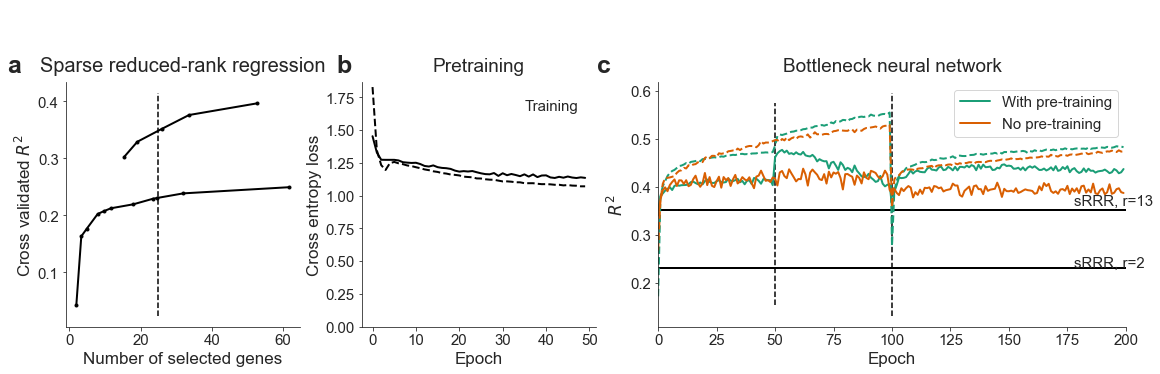

In [42]:
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    cr_13= np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    r_rank13_r = np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_13[1:], cr_13[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
#ax1.set_ylim([0.3,0.45])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=13', (70, np.max(cr_13)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (70, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Test', (35, 2.36), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[1,0,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[1,0,:], \
         c = '#1b9e77', linewidth=linewidth, label='With pre-training')
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,0,:], \
#          '--', c = '#d95f02', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,0,:], \
#          c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
         c = '#d95f02', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank13_r[np.isclose(n_rank13, 25, atol=5)][0], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=5)][0], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
#ax3.set_ylim([0.3,0.45])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('sRRR, r=13', (178, r_rank13_r[np.isclose(n_rank13, 25, atol=5)][0]+0.01), fontsize=15)
ax3.annotate('sRRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=5)][0]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='best', fontsize=15)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Lasso_training_curves_stoeckius.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Lasso_training_curves_stoeckius.png', bbox_inches='tight',
    pad_inches=0)